### Importing Libaries ###

In [35]:
#Library imports
import re
import os
import time
import math
import random
import itertools
import numpy as np
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#Notebook arguments
%matplotlib inline

# Importing Data

In [36]:
#Importing pickle 
vix_model_data = pd.read_pickle("vix.pickle")

In [37]:
#Checking dataframe
vix_model_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-23,26.930000,28.549999,26.540001,26.910000,26.910000,0
1,2010-06-24,27.610001,30.270000,27.530001,29.740000,29.740000,0
2,2010-06-25,29.639999,30.410000,28.070000,28.530001,28.530001,0
3,2010-06-28,29.200001,29.900000,28.469999,29.000000,29.000000,0
4,2010-06-29,31.219999,35.389999,31.219999,34.130001,34.130001,0


In [38]:
#Sanity Check
vix_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
Date         2518 non-null object
Open         2518 non-null float64
High         2518 non-null float64
Low          2518 non-null float64
Close        2518 non-null float64
Adj Close    2518 non-null float64
Volume       2518 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [39]:
# Dropping columns Open, High, Low, Close and Volume 
columns_not_reqd = ['Open','High','Low','Close','Volume']
vix_model_data.drop(columns=columns_not_reqd,inplace=True)
vix_model_data.head()

,Date,Adj Close
0,2010-06-23,26.910000
1,2010-06-24,29.740000
2,2010-06-25,28.530001
3,2010-06-28,29.000000
4,2010-06-29,34.130001


In [40]:
#Sanity Check
vix_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
Date         2518 non-null object
Adj Close    2518 non-null float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [41]:
#Converting Date to Datetime Stamp
vix_model_data["Date"] = pd.to_datetime(vix_model_data["Date"])

In [42]:
# Setting Date as Index
vix_model_data.set_index('Date', inplace=True)

In [43]:
# Rename column 
vix_model_data.rename(columns={"Adj Close": "adjclose"},inplace=True)

In [44]:
#Sanity Check
vix_model_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-06-23 to 2020-06-23
Data columns (total 1 columns):
adjclose    2518 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


In [45]:
vix_model_data.describe()

,adjclose
count,2518.000000
mean,17.336775
std,7.288730
min,9.140000
25%,13.020000
50%,15.375000
75%,19.020000
max,82.690002


#### The mean for this data set is ~17 with a minimum recorded index value of 9.14 (on 3rd November 2017) and a maximum recorded index value of 82.69 on March 16th 2020  (Previous record set on 80.74 on Nov. 21 2008) ####

In [46]:
vix_model_data.head()

,adjclose
Date,
2010-06-23,26.910000
2010-06-24,29.740000
2010-06-25,28.530001
2010-06-28,29.000000
2010-06-29,34.130001


In [47]:
#Settting equal to new varible vix_clean
vix_clean = vix_model_data

In [48]:
#Exporting cleaned, timestamped data as a Pickle for other models 
vix_model_data.to_pickle('vix_clean.pickle')

## Exploratory Data Analysis ## 

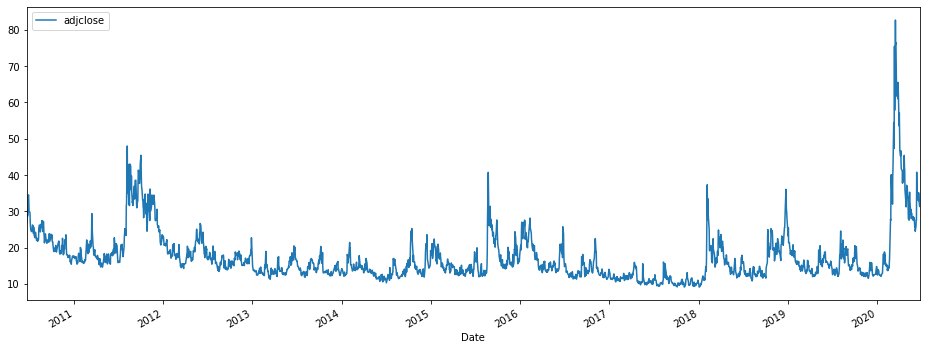

In [49]:
# Visualizing a line plot using vix and .plot() method 
vix_clean.plot(figsize = (16,6))

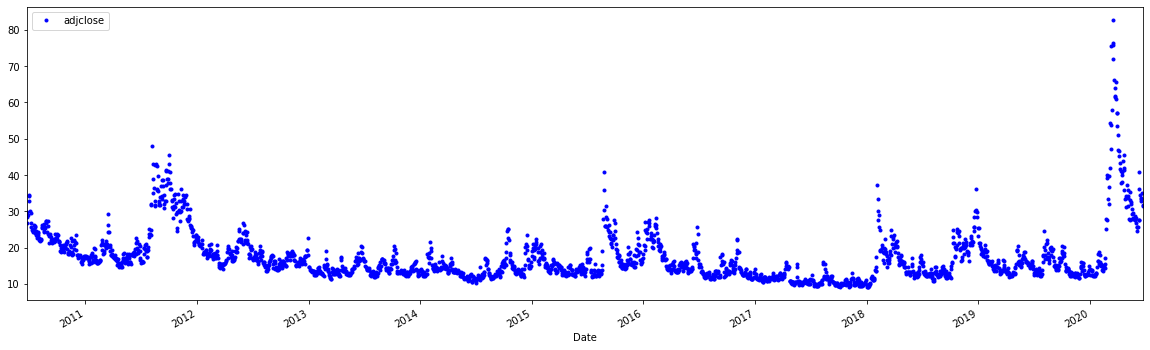

In [50]:
# Visualizing a dot plot using temp and .plot() method 
vix_clean.plot(figsize = (20,6), style = '.b');

#### Clearly the visualizations above alludes the 'long term mean reversion' characteristic of the Index  ####

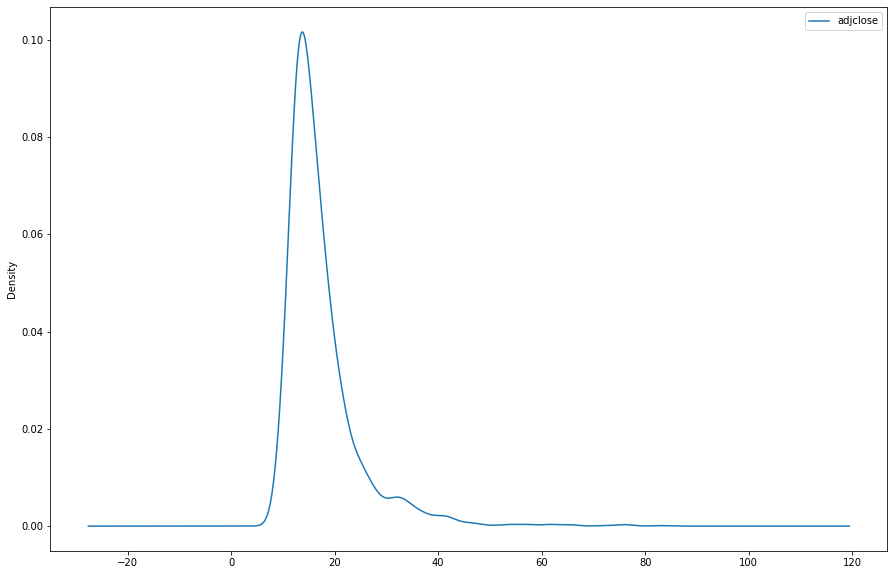

In [51]:
# Plot a density plot for dataset
vix_clean.plot(kind='kde', figsize = (15,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131bf4b90>]],
      dtype=object)

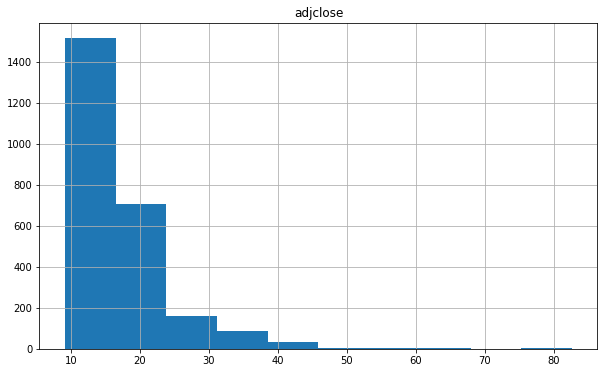

In [52]:
# Visualizing distribution of index values aka'fear levels' over the 10 years of data
vix_clean.hist(figsize = (10,6))

#### We can see that maximum number of observations lie within an index value of 10-20 (low volatility expectation). This is expected since investors dont like to be in a heighted state of fear or flight all the time ####

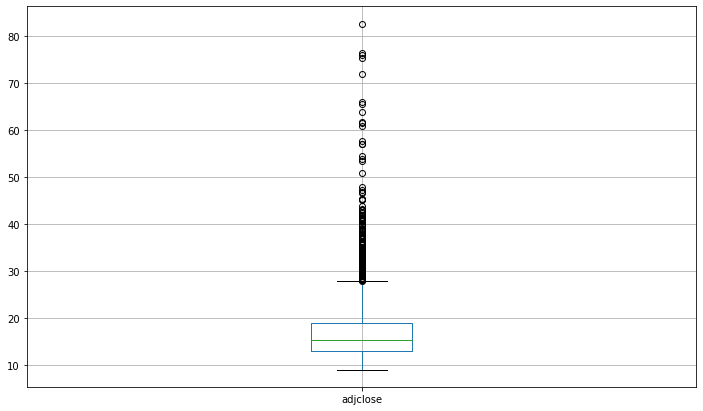

In [53]:
# Generate a box and whiskers plot for Vix
vix_clean.boxplot(figsize = (12,7));

#### The boxplot is useful in getting a different perspective on the distribution of index values. One possible interpretaton could be that investors have a 1/4th chance of panicking (Index Value >30 ~ considerable increase in fear levels) on any given day in the last 10 years ####

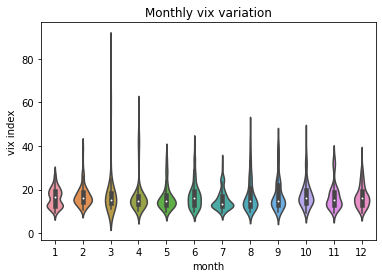

In [59]:
#visually evaluating which months typically see the maximum volatility 
ax = sns.violinplot(x=vix_clean.index.month,y=vix_clean['adjclose']) 
ax.set(xlabel='month', ylabel='vix index', title='Monthly vix variation');

As also verified by EDA features in Prophet (refer vix_prophet_1), March-April and June-July see maximum volatility possibly due to release of Q1 & Q2 earnings which lead to rebalancing of portofolios using futures and consequently impacting a derivative index like VIX (Helps to think VIX is a derivative of the futures market)

### Exploring Resampling  ###
(may be used for hyperparamter tuning of ARIMA)

In [29]:
vix_monthly = vix_clean.resample('MS')
vix_month_mean = vix_monthly.mean()

In [30]:
vix_month_mean.head()

,adjclose
Date,
2010-06-01,30.475001
2010-07-01,25.565238
2010-08-01,24.745909
2010-09-01,22.517619
2010-10-01,20.373333


In [31]:
vix_month_mean.to_pickle('vix_monthly.pickle')

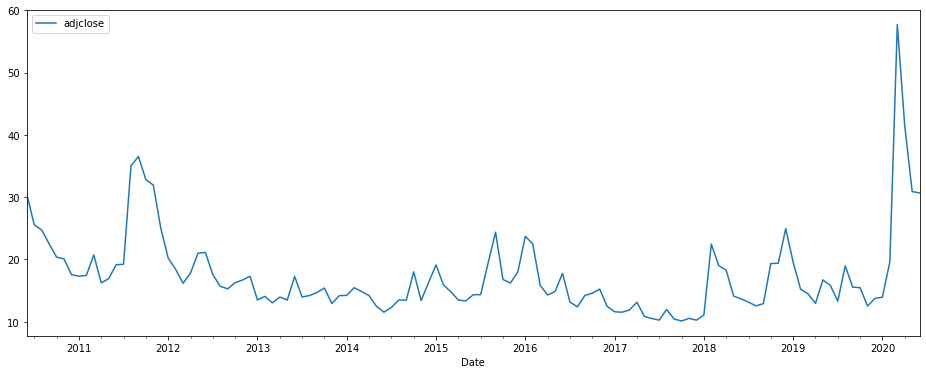

In [32]:
# Draw a line plot using nyse and .plot() method 
vix_month_mean.plot(figsize = (16,6));

In [33]:
vix_weekly = vix_clean.resample('W')
vix_weekly_mean = vix_weekly.mean()

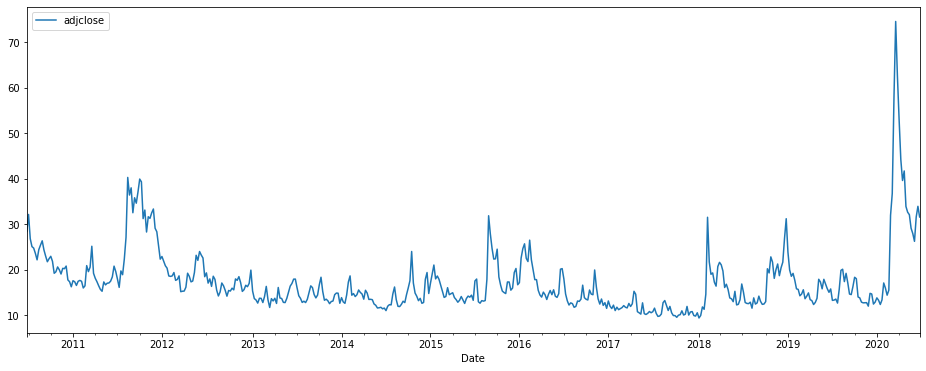

In [34]:
# Draw a line plot using nyse and .plot() method 
vix_weekly_mean.plot(figsize = (16,6));

Resampling doesnt make a big difference to the series attesting to the 'relative volatility' concept where future short-term volatility builds on previous near -term volatility expectations - Resampling on a weekly basis or a monthly basis doesnt show much because barring rare exceptional events - investor expectations of future volatility grow from short term historic movement of index and the index for most part doesnt change too rapidly i.e. market takes time to process and react to new information 

# End of preprocessing and EDA for MVP

#### Now lets compare how volatility index has performed through the years####

In [61]:
# Grouping data from 2011-2019 (excluded broken periods from both end to exlcude impact of COVID-19)
data_2011_onwards = vix_clean['2011':'2019']
print(data_2011_onwards.head())
print(data_2011_onwards.tail())

             adjclose
Date                 
2011-01-03  17.610001
2011-01-04  17.379999
2011-01-05  17.020000
2011-01-06  17.400000
2011-01-07  17.139999
            adjclose
Date                
2019-12-24     12.67
2019-12-26     12.65
2019-12-27     13.43
2019-12-30     14.82
2019-12-31     13.78


In [62]:
#Sanity Check 
data_2011_onwards.isnull().sum()

adjclose    0
dtype: int64

In [63]:
data_2011_onwards.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2011-01-03 to 2019-12-31
Data columns (total 1 columns):
adjclose    2264 non-null float64
dtypes: float64(1)
memory usage: 35.4 KB


In [68]:
year_groups = data_2011_onwards.groupby(pd.TimeGrouper('B')) 

AttributeError: module 'pandas' has no attribute 'TimeGrouper'

In [64]:
# Use pandas grouper to group values using annual frequency



year_groups = data_2011_onwards.groupby(pd.Grouper(freq ='B'))

In [41]:
print(year_groups.head())
print(year_groups.tail())

             adjclose
Date                 
2011-01-03  17.610001
2011-01-04  17.379999
2011-01-05  17.020000
2011-01-06  17.400000
2011-01-07  17.139999
...               ...
2019-12-24  12.670000
2019-12-26  12.650000
2019-12-27  13.430000
2019-12-30  14.820000
2019-12-31  13.780000

[2264 rows x 1 columns]
             adjclose
Date                 
2011-01-03  17.610001
2011-01-04  17.379999
2011-01-05  17.020000
2011-01-06  17.400000
2011-01-07  17.139999
...               ...
2019-12-24  12.670000
2019-12-26  12.650000
2019-12-27  13.430000
2019-12-30  14.820000
2019-12-31  13.780000

[2264 rows x 1 columns]


In [67]:
# Create a new DataFrame and store yearly values in columns 
index_annual = pd.DataFrame()

for yr, group in year_groups:
    index_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
index_annual.plot(figsize = (13,8), subplots=True, legend=True);

ValueError: Length of values does not match length of index

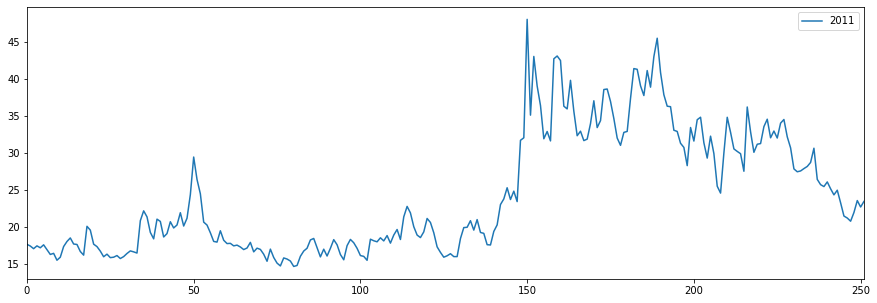

In [25]:
# Plot overlapping yearly groups 
index_annual.plot(figsize = (15,5), subplots=False, legend=True);

In [42]:
# Subtract the moving average from the original data
data_minus_roll_mean = vix_clean - roll_mean
data_minus_roll_mean.head(15)

,adjclose
Date,
2010-06-23,NaN
2010-06-24,NaN
2010-06-25,NaN
2010-06-28,0.455000
2010-06-29,3.780000
2010-06-30,2.990000
2010-07-01,0.227500
2010-07-02,-2.792500
2010-07-06,-2.142501


In [43]:
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)

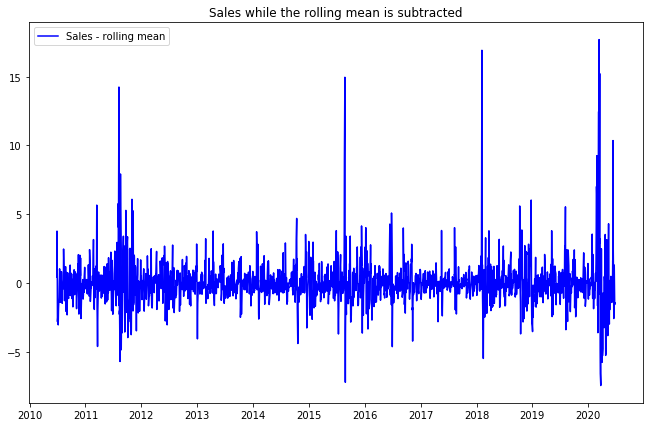

In [44]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

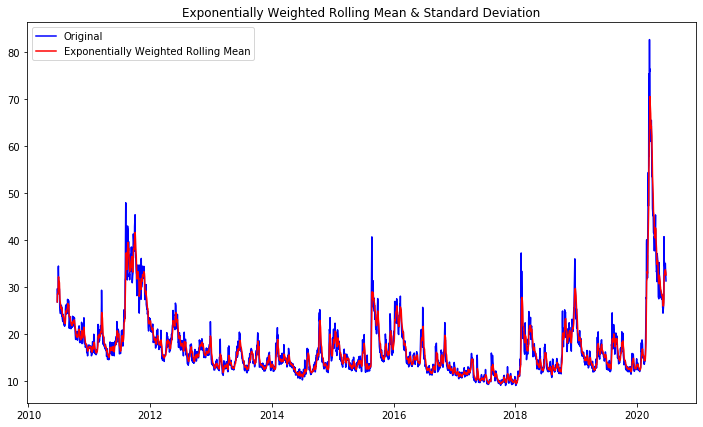

In [49]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = vix_clean.ewm(halflife=2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(vix_clean, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [50]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = vix_clean - exp_roll_mean
data_minus_exp_roll_mean.head(15)

,adjclose
Date,
2010-06-23,0.000000
2010-06-24,1.172224
2010-06-25,-0.020660
2010-06-28,0.273861
2010-06-29,3.481231
2010-06-30,2.588700
2010-07-01,0.616742
2010-07-02,-1.459911
2010-07-06,-1.338518


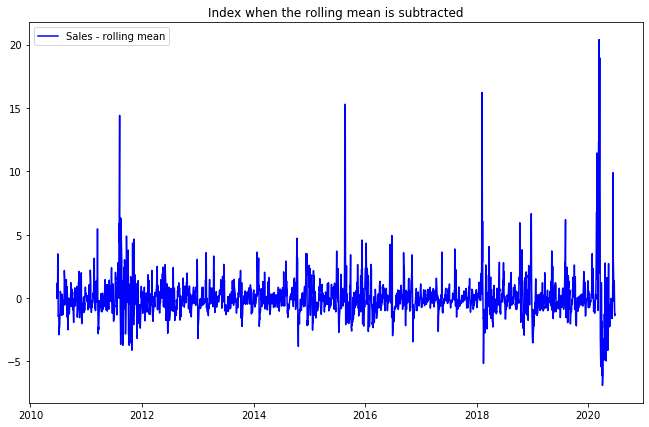

In [51]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Index when the rolling mean is subtracted')
plt.show(block=False)

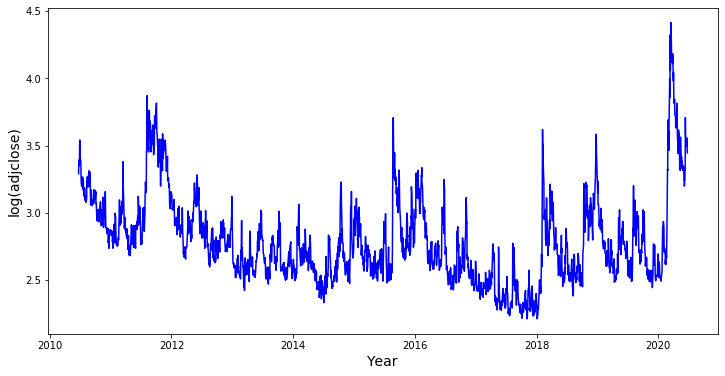

In [52]:
# Trying a log transformation to see if stationarity is achieved 
data = pd.Series(np.log(vix_clean['adjclose']))
fig = plt.figure(figsize=(12,6))
plt.plot(data, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('log(adjclose)', fontsize=14)
plt.show()